In [33]:
import numpy as np
import skimage.io as io
import skimage.color as color
from skimage import transform
from numpy.lib import stride_tricks
import matplotlib.pyplot as plt
import os, sys
import random
import cv2
import math

#print numpy array without scientific notation
np.set_printoptions(suppress=True)

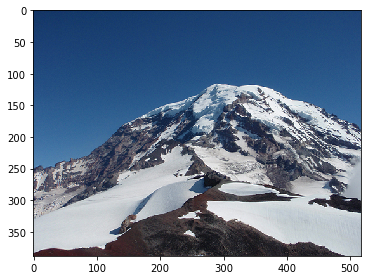

In [34]:
img = io.imread("Rainier1.png")
#Convert to RGB from RGBA (if applicable)
if img.ndim == 3 and img.shape[2] == 4:
    img = color.rgba2rgb(img)
io.imshow(img)

In [35]:
def random_crop(img, size):
    w, h = img.shape[0], img.shape[1]
    if size > min(w,h):
        sys.exit("cropping size is not feasible")
    x = random.randint(0, w - size)
    y = random.randint(0, h - size)
    return img[x:x + size, y:y + size]

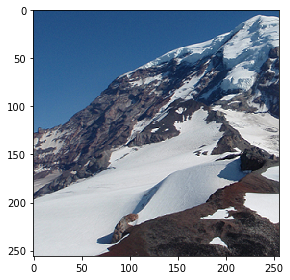

In [36]:
cropped_img = random_crop(img, 256)
io.imshow(cropped_img)

In [37]:
def nonOverlappingPatches(img, size):
    H, W = img.shape
    rows, cols = H//size, W//size
    
    patches = np.zeros((rows, cols, size, size))
    
    for i in range(rows):
        for j in range(cols):
            patches = img[size*i:size*(i+1), size*j:size*(j+1)]

In [38]:
def extract_patches(img, size):
    H, W, C = img.shape
    shape = [H//size, W//size] + [size, size, C]
    strides = [size*s for s in img.strides[:2]] + list(img.strides)
    patches = stride_tricks.as_strided(img, shape=shape, strides=strides)
    
    return patches
    

In [39]:
patches = extract_patches(cropped_img, 32)
print(patches.shape)

(8, 8, 32, 32, 3)


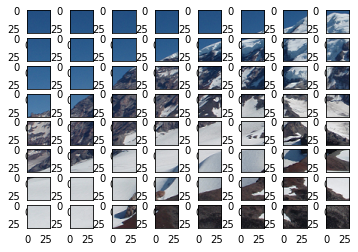

In [40]:
fig = plt.figure()
nrows = patches.shape[0]
ncols = patches.shape[1]

for i in range(nrows):
    for j in range(ncols):
        idx = nrows*i + j
        ax = fig.add_subplot(nrows, ncols, idx+1)
        ax.imshow(patches[i][j])
        ax.tick_params(left = False, right=False, bottom=False, top=False)
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


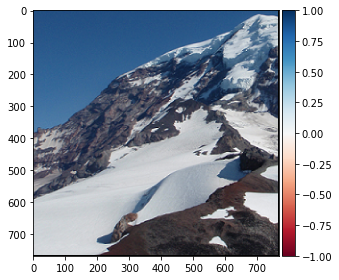

In [41]:
import numpy as np
import math

def bilinear_resize(img, factor):
    # Convert to RGB from RGBA (if applicable)
    if img.ndim == 3 and img.shape[2] == 4:
        img = color.rgba2rgb(img)

    H, W = img.shape[:2]

    new_H = int(H * factor)
    new_W = int(W * factor)
    

    # init new_img matrix
    new_img = np.empty(shape=(new_H, new_W, 3))

    for i in range(new_H):
        for j in range(new_W):
            # find the coordinate when map the pixel from resized img to original img
            x = i / new_H * H
            y = j / new_W * W
            
            nb_x1 = int(x)
            nb_x2 = int(x) + 1
            nb_y1 = int(y)
            nb_y2 = int(y) + 1
            #if out of boundaries
            if nb_x2 >= H:
                nb_x2 = H - 1
            if nb_y2 >= W:
                nb_y2 = W - 1

            # calculate weights for surrounding pixels
            w1 = (nb_x2 - x) * (nb_y2 - y)
            w2 = (nb_x2 - x) * (y - nb_y1)
            w3 = (x - nb_x1) * (nb_y2 - y)
            w4 = (x - nb_x1) * (y - nb_y1)

            # calculate new pixel value
            new_pixel = w1 * img[nb_x1, nb_y1] + w2 * img[nb_x1, nb_y2] + w3 * img[nb_x2, nb_y1] + w4 * img[nb_x2, nb_y2]
            new_img[i, j] = new_pixel

    return new_img

                        
#print numpy array without scientific notation
np.set_printoptions(suppress=True)
resized_img = bilinear_resize(cropped_img, 3)
io.imshow(resized_img)

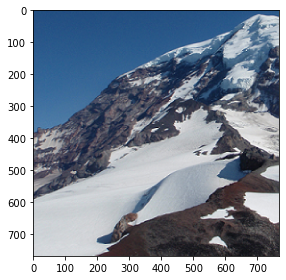

In [42]:
def bilinear_interpolation(image, resize_factor):
    # Get the shape of the input image
    height, width = image.shape[:2]
    
    # Calculate the new size of the image
    new_height, new_width = int(height * resize_factor), int(width * resize_factor)
    
    #init new_img matrix
    resized_image = np.empty(shape = [new_height, new_width, 3])
    
    # Calculate the scaling factor for the x and y axis
    x_scale, y_scale = float(width) / new_width, float(height) / new_height
    
    for x in range(new_width):
        for y in range(new_height):
            # Calculate the corresponding x and y indices in the original image
            original_x, original_y = x * x_scale, y * y_scale

            
            # Calculate the integer part and fractional part of the indices
            x0, y0 = int(original_x), int(original_y)
            x1, y1 = x0 + 1, y0 + 1
            
            # Clamp the indices to the bounds of the original image
            x0, x1 = min(x0, width - 1), min(x1, width - 1)
            y0, y1 = min(y0, height - 1), min(y1, height - 1)
            
            # Calculate the four closest pixel values
            f00 = image[y0][x0]
            f01 = image[y0][x1]
            f10 = image[y1][x0]
            f11 = image[y1][x1]
            
            # Calculate the fractional part of the original indices
            tx, ty = original_x - x0, original_y - y0
            
            # Interpolate the four closest pixel values using bilinear interpolation
            resized_image[y][x] = f00 * (1 - tx) * (1 - ty) + f01 * tx * (1 - ty) + f10 * (1 - tx) * ty + f11 * tx * ty
            
    return resized_image

resized_img = bilinear_interpolation(cropped_img, 3)
io.imshow(resized_img)

In [26]:
def rgb_to_hsv(img_rgb):
    #normalize if rgb still in [0,255]
    if img_rgb.dtype == np.uint8 or img_rgb.dtype == np.uint16:
        img_rgb = np.array(img_rgb, dtype=float) / 255.
    
    #init img_hsv matrix
    img_hsv = np.empty_like(img_rgb)

    #calculate the Value matrix
    #V = img_rgb.max(-1) #alternative way
    V = np.max(img_rgb, axis =2)
    
    #calculate the Chroma matrix, also called delta in some resource
    #delta = img_rgb.ptp(-1) #alternative way
    C = V - np.min(img_rgb, axis=2)

    #calculate the Saturation matrix
    #noticed that: S = C/V. If V=0, then S=0
    #S = np.divide(C,V, out=np.zeros_like(C), where=V!=0)
    Ignore_divided_0 = np.seterr(invalid='ignore')
    S = C / V
    S[C == 0.] = 0.

    # Calculate the Hue Matrix
    # we will store the H' in img_hsv[idx, 0] temporarily
    # red is max
    idx = (img_rgb[..., 0] == V)
    img_hsv[idx, 0] = ((img_rgb[idx, 1] - img_rgb[idx, 2]) / C[idx]) % 6
    
    # green is max
    idx = (img_rgb[..., 1] == V)
    img_hsv[idx, 0] = 2. + (img_rgb[idx, 2] - img_rgb[idx, 0]) / C[idx]
    
    # blue is max
    idx = (img_rgb[..., 2] == V)
    img_hsv[idx, 0] = 4. + (img_rgb[idx, 0] - img_rgb[idx, 1]) / C[idx]
    
    #H = (img_hsv[..., 0] / 6.) % 1. #this is if we want to normalize H to be in [0,1]
    H = img_hsv[..., 0]*60. #this is for H in [0,360] degree
    # if C = 0
    H[C == 0.] = 0.
    
    np.seterr(**Ignore_divided_0)

    #combine all HSV components
    img_hsv[..., 0] = H
    img_hsv[..., 1] = S
    img_hsv[..., 2] = V

    # set all nan to 0
    img_hsv[np.isnan(img_hsv)] = 0
    
    return img_hsv

def hsv_to_rgb(img_hsv):
    #init img_rgb matrix
    img_rgb = np.empty_like(img_hsv)

    # generate 3 separated matrix for H, S, V
    H = img_hsv[..., 0]
    S = img_hsv[..., 1]
    V = img_hsv[..., 2]

    # Calcualte Chroma matrix
    C = V*S

    # H' matrix
    H_prime = H/60

    # X matrix
    X = C * (1- abs(H_prime%2 - 1))

    # convert H' to the condition, that is used to calculate R', G', B' later
    H_prime = H_prime.astype(int) % 6

    # m matrix
    m = V - C

    #calculate R',G',B' according to the condition of H', then add m[idx] to get RGB (see class notes)
    idx = H_prime[...] == 0
    img_rgb[idx, 0] = C[idx] + m[idx]
    img_rgb[idx, 1] = X[idx] + m[idx]
    img_rgb[idx, 2] = m[idx]

    idx = H_prime[...] == 1
    img_rgb[idx, 0] = X[idx] + m[idx]
    img_rgb[idx, 1] = C[idx] + m[idx]
    img_rgb[idx, 2] = m[idx]

    idx = H_prime[...] == 2
    img_rgb[idx, 0] = m[idx]
    img_rgb[idx, 1] = C[idx] + m[idx]
    img_rgb[idx, 2] = X[idx] + m[idx]

    idx = H_prime[...] == 3
    img_rgb[idx, 0] = m[idx]
    img_rgb[idx, 1] = X[idx] + m[idx]
    img_rgb[idx, 2] = C[idx] + m[idx]

    idx = H_prime[...] == 4
    img_rgb[idx, 0] = X[idx] + m[idx]
    img_rgb[idx, 1] = m[idx]
    img_rgb[idx, 2] = C[idx] + m[idx]

    idx = H_prime[...] == 5
    img_rgb[idx, 0] = C[idx] + m[idx]
    img_rgb[idx, 1] = m[idx]
    img_rgb[idx, 2] = X[idx] + m[idx]
    
    return img_rgb

def modify_img(img, h, s, v):
    img_hsv = rgb_to_hsv(img)
    img_hsv[..., 0] = (img_hsv[..., 0] + h) % 360
    img_hsv[..., 1] = (img_hsv[..., 1] + s) % 1
    img_hsv[..., 2] = (img_hsv[..., 2] + v) % 1

    img_rgb = hsv_to_rgb(img_hsv)
    return img_rgb

In [43]:
def color_jitter(img, hue, saturation, value):
    hue = float(hue)
    if not (0<= hue <= 360):
        sys.exit("Heu must be in [0, 360]")

    saturation = float(saturation)
    if not (0<= saturation <= 1):
        sys.exit("Saturation must be in [0, 1]")

    value = float(value)
    if not (0<= value <= 1):
        sys.exit("Value must be in [0, 1]")
    
    h = random.uniform(0, hue)
    s = random.uniform(0, saturation)
    v = random.uniform(0, value)
    
    return modify_img(img, h, s, v)


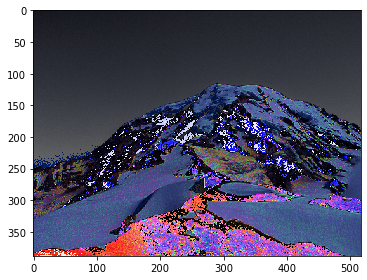

In [44]:
random_img = color_jitter(img, 90, 0.8, 0.8)
io.imshow(random_img)

In [31]:
def resize_img(img, factor):
    #Convert to RGB from RGBA (if applicable)
    if img.ndim == 3 and img.shape[2] == 4:
        img = color.rgba2rgb(img)

    H, W = img.shape[:2]
   
    new_H = math.floor(H*factor)
    new_W = math.floor(W*factor)
    
    #init new_img matrix
    new_img = np.empty(shape = [new_H, new_W, 3])
    
    for i in range(new_H):
        for j in range(new_W):
            #cross product of the transformation matrix and scaled img coordinate pixel
            x = math.floor(i*(1/factor))
            y = math.floor(j*(1/factor))
            
            #assign new_img pixel by the original img pixel
            new_img[i,j] = img[x,y]
    
    return new_img

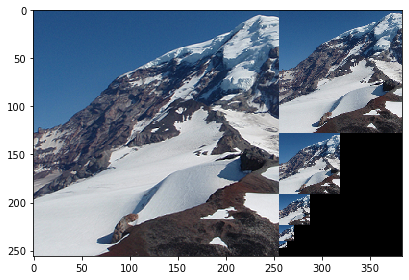

In [45]:
def pyramid_img(img, height):
    '''
    code from Dr. Dillhoff Github repo
    
    rows, cols, channels = img.shape
    # Create tuple of downscaled images
    pyramid = tuple(transform.pyramid_gaussian(img, downscale=2, multichannel=True))

    comp_img = np.zeros((rows, cols+cols // 2, channels), dtype=np.double)
    # Place the largest (original) image first
    comp_img[:rows, :cols, :] = pyramid[0]

    # Add in the other images
    i_row = 0
    h = 0
    for p in pyramid[1:]:
        n_rows, n_cols = p.shape[:2]
        comp_img[i_row:i_row + n_rows, cols:cols + n_cols, :] = p
        i_row += n_rows
        h+=1
        if h == height:
            break
    '''
    rows, cols, channels = img.shape
    comp_img = np.zeros((rows, cols+cols // 2, channels), dtype=np.double)
    # Place the largest (original) image first
    comp_img[:rows, :cols, :] = img
    
    pre_img = img
    i_row = 0
    for i in range(height):
        pre_img = resize_img(pre_img, 1/2)
        n_rows, n_cols = pre_img.shape[:2]
        comp_img[i_row:i_row + n_rows, cols:cols + n_cols, :] = pre_img
        i_row += n_rows
    
    
    return comp_img

pyramid = pyramid_img(cropped_img, 5)
io.imshow(pyramid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


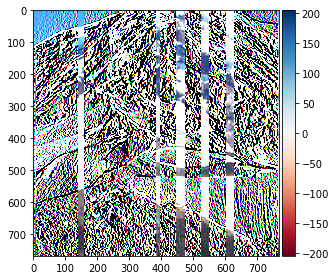

In [15]:
def bilinear_resize(img, factor):
    #Convert to RGB from RGBA (if applicable)
    if img.ndim == 3 and img.shape[2] == 4:
        img = color.rgba2rgb(img)

    H, W = img.shape[:2]
   
    new_H = math.floor(H*factor)
    new_W = math.floor(W*factor)
    
    #init new_img matrix
    new_img = np.empty(shape = [new_H, new_W, 3])
    
    #solve the equation
    B = np.array([-0.5, W-0.5])
    A = np.array([[-0.5,1],[new_W-0.5,1]] )
    X = np.linalg.inv(A).dot(B)
    
    
    for i in range(new_H):
        for j in range(new_W):
            #find the coordinate when map the pixel from resized img to original img
            x = i*X[0] + X[1]
            y = j*X[0] + X[1] 
            #assume a pixel have shape like this
            new_pixel = [0,0,0]
            for k in range(4):
                if k==0:
                    nb_x = int(x)
                    nb_y = int(y)
                    new_pixel += (1-x)*img[nb_x,nb_y]
                elif k==1:
                    nb_x = int(x)
                    nb_y = W-1 if y> W-1 else math.ceil(y)
                    new_pixel += x*img[nb_x,nb_y]
                elif k==2:
                    nb_x = H-1 if x>H-1 else math.ceil(x)
                    nb_y = int(y)
                    new_pixel += (1-y)*img[nb_x, nb_y]
                elif k==3:
                    nb_x = H-1 if x>H-1 else math.ceil(x)
                    nb_y = W-1 if y> W-1 else math.ceil(y)
                    new_pixel += y*img[nb_x, nb_y]
            new_img[i,j] = new_pixel
                    
            
    return new_img
                        
resized_img = bilinear_resize(cropped_img, 3)
io.imshow(resized_img)
